In [1]:
import numpy as np
import torch

In [3]:
# Input (temp, rainfall, humidity)
inputs = torch.tensor([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype=torch.float32)

In [4]:
inputs

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])

In [6]:
# Targets (apples, oranges)
targets = torch.tensor([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype=torch.float32)

In [7]:
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

torch.randn creates a tensor with the given shape, with elements picked randomly from a normal distribution with mean 0 and standard deviation 1.

In [20]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[-0.6054, -0.5836, -1.1243],
        [-1.6971,  0.7239,  0.2608]], requires_grad=True)
tensor([-1.0504, -0.0023], requires_grad=True)


Our model is simply a function that performs a matrix multiplication of the inputs and the weights w (transposed) and adds the bias b (replicated for each observation).

    Equation : y= x * w.t() + b --> '*' stands for bit wise multiplication
        where x -> input matrix
              w.t() --> transpose of weights matrix
              b --> bias cumulative sums of Targets


In [21]:
def regression_model(x):
    y= x @ w.t() + b
    return y

In [22]:
y_pred = regression_model(inputs)
y_pred

tensor([[-132.6963,  -64.1726],
        [-179.4615,  -74.0407],
        [-197.1406,  -35.5159],
        [-129.5003, -132.3287],
        [-177.5573,  -29.3475]], grad_fn=<AddBackward0>)

In [23]:
def mean_square_error(y_actual,y_pred):
    diff = y_actual - y_pred
    return torch.sum(diff * diff)/diff.numel()

In [24]:
loss = mean_square_error(targets,y_pred)
loss

tensor(43277.4492, grad_fn=<DivBackward0>)

In [25]:
loss.backward()

In [27]:
w.grad

tensor([[-19958.5098, -22274.8242, -13672.8320],
        [-13578.3389, -13699.3555,  -8679.0879]])

Adjust the Weights to Reduce Loss 

The loss is a quadratic function of our weights and biases, and our objective is to find the set of weights where the loss is the lowest. If we plot a graph of the loss w.r.t any individual weight or bias element, it will look like the figure shown below. An important insight from calculus is that the gradient indicates the rate of change of the loss, i.e., the loss function's slope w.r.t. the weights and biases.

If a gradient element is positive:

    increasing the weight element's value slightly will increase the loss
    decreasing the weight element's value slightly will decrease the loss
    
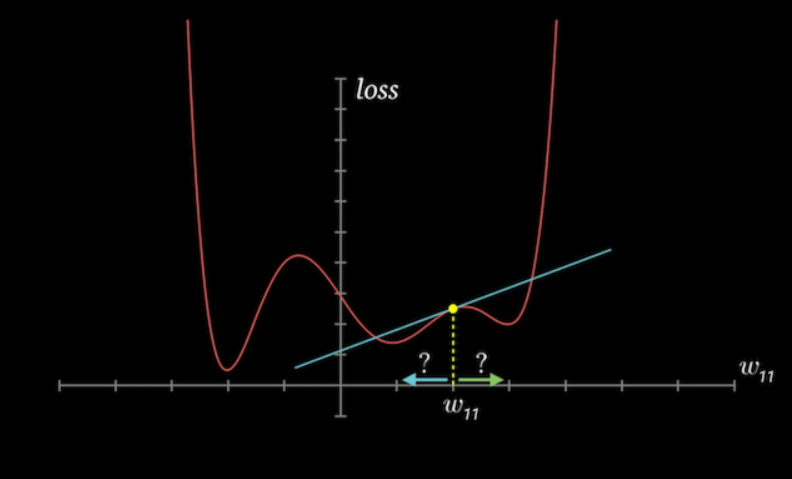

If a gradient element is negative:

    increasing the weight element's value slightly will decrease the loss
    decreasing the weight element's value slightly will increase the loss
    

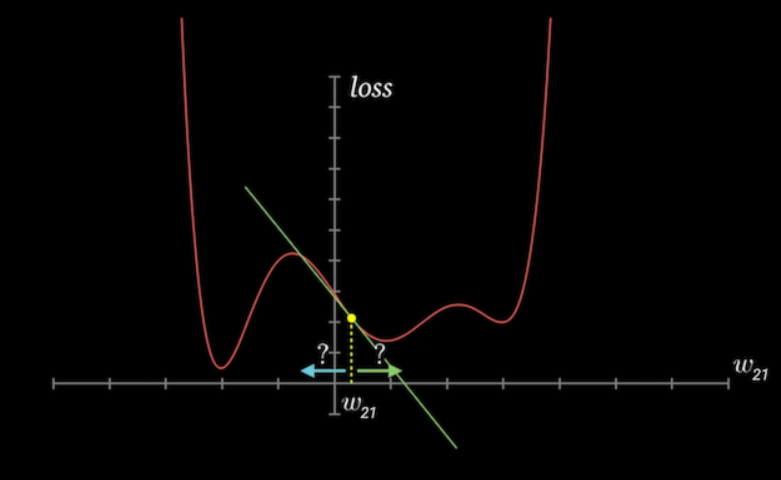

The increase or decrease in the loss by changing a weight element is proportional to the gradient of the loss w.r.t. that element. This observation forms the basis of the gradient descent optimization algorithm that we'll use to improve our model (by descending along the gradient).

We can subtract from each weight element a small quantity proportional to the derivative of the loss w.r.t. that element to reduce the loss slightly.


In [28]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

We multiply the gradients with a very small number (10^-5 in this case) to ensure that we don't modify the weights by a very large amount. We want to take a small step in the downhill direction of the gradient, not a giant leap. This number is called the learning rate of the algorithm.

We use torch.no_grad to indicate to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases.

In [29]:
w

tensor([[-0.4058, -0.3609, -0.9876],
        [-1.5613,  0.8609,  0.3476]], requires_grad=True)

In [30]:
b

tensor([-1.0481e+00, -7.1877e-04], requires_grad=True)

In [31]:
# Let's verify that the loss is actually lower
loss = mean_square_error(targets,y_pred)
print(loss)

tensor(43277.4492, grad_fn=<DivBackward0>)


Before we proceed, we reset the gradients to zero by invoking the .zero_() method. We need to do this because PyTorch accumulates gradients. Otherwise, the next time we invoke .backward on the loss, the new gradient values are added to the existing gradients, which may lead to unexpected results.

In [32]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


Train the model using gradient descent
As seen above, we reduce the loss and improve our model using the gradient descent optimization algorithm. Thus, we can train the model using the following steps:

    Generate predictions

    Calculate the loss

    Compute gradients w.r.t the weights and biases

    Adjust the weights by subtracting a small quantity proportional to the gradient

    Reset the gradients to zero

Let's implement the above step by step.

In [33]:
# Generate Prredictions 
y_pred = regression_model(inputs)
y_pred

tensor([[ -97.3208,  -41.3483],
        [-132.9444,  -44.0728],
        [-141.9958,   -0.3101],
        [ -94.5032, -109.3752],
        [-132.8287,   -0.7502]], grad_fn=<AddBackward0>)

In [34]:
# Calculate the loss
loss = mean_square_error(targets,y_pred)
print(loss)

tensor(29356.8379, grad_fn=<DivBackward0>)


In [35]:
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[-16304.7002, -18344.4473, -11248.3242],
        [-11224.2109, -11176.0879,  -7120.6025]])
tensor([-196.1186, -131.1713])


In [36]:
# Adjust weights & reset gradients
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [40]:
# Generate Prredictions 
y_pred = regression_model(inputs)
y_pred


tensor([[-68.2888, -22.6034],
        [-94.7631, -19.4653],
        [-96.7032,  28.5622],
        [-65.8204, -90.4848],
        [-96.0920,  22.7093]], grad_fn=<AddBackward0>)

In [41]:
# Calculate the loss
loss = mean_square_error(targets,y_pred)
print(loss)

tensor(19973.7148, grad_fn=<DivBackward0>)


In [59]:
# Train for 100 epochs
for i in range(900):
    # Generate Prredictions 
    y_pred = regression_model(inputs)
    # Calculate the loss
    loss = mean_square_error(targets,y_pred)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [60]:
# Generate Prredictions 
y_pred = regression_model(inputs)
y_pred


tensor([[ 57.0562,  70.3265],
        [ 81.7714, 100.5390],
        [119.8554, 133.2289],
        [ 21.4211,  37.0909],
        [100.7599, 118.8678]], grad_fn=<AddBackward0>)

In [61]:
# Calculate the loss
loss = mean_square_error(targets,y_pred)
print(loss)

tensor(0.8193, grad_fn=<DivBackward0>)


In [62]:
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

In [63]:
y_pred

tensor([[ 57.0562,  70.3265],
        [ 81.7714, 100.5390],
        [119.8554, 133.2289],
        [ 21.4211,  37.0909],
        [100.7599, 118.8678]], grad_fn=<AddBackward0>)